# User-Itemset Classification: Frequent Itemset Approaches

Author: Quang Minh Nguyen

## Importing libraries and data

In [132]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt 
# sparse matrix processing
from scipy.sparse import coo_matrix, csr_matrix, bmat
from scipy.sparse.linalg import svds
# clustering
from sklearn.cluster import KMeans
# general
from tqdm import tqdm
import os
from collections import defaultdict
from time import time

In [133]:
# import the data
itemset_item_training = np.loadtxt('dataset/itemset_item_training.csv', delimiter=',', dtype=int)
user_item = np.loadtxt('dataset/user_item.csv', delimiter=',', dtype=int)
user_itemset_training = np.loadtxt('dataset/user_itemset_training.csv', delimiter=',', dtype=int)
user_itemset_valid_query = np.loadtxt('dataset/user_itemset_valid_query.csv', delimiter=',', dtype=int)
user_itemset_valid_answer = np.loadtxt('dataset/user_itemset_valid_answer.csv', delimiter=',', dtype=int)
user_itemset_test_query = np.loadtxt('dataset/user_itemset_test_query.csv', delimiter=',', dtype=int)

## Utility functions

We build a simple function to get accuracy give predictions and ground truth.

In [134]:
def get_accuracy(predictions, ground_truth):
    """Calculate the accuracy for binary predictions.
    
    Parameters:
        predictions: list[int], each element is 1 or 0
        ground_truth: list[int], each element is 1 or 0

    Returns:
        float, the accuracy of the prediction on the validation set
    """
    return np.mean(predictions == ground_truth)

In [135]:
def get_SVD_embeddings(matrix, k):
    """
    Get the SVD embeddings for users and items.

    Parameters:
        matrix: np.array, the matrix to be factorized
        k: int, number of latent factors
    
    Returns:
        U: np.array, user embeddings
        V: np.array, itemset embeddings
    """
    U, _, V = svds(matrix, k=k)
    return U, V

## Frequently used variables and function

In [136]:
sparse_user_itemset = coo_matrix(
    ([1]*len(user_itemset_training), 
    (user_itemset_training[:, 0], user_itemset_training[:, 1])), 
    dtype=float)
sparse_user_itemset_csr = sparse_user_itemset.tocsr()  # in csr format
sparse_user_itemset_csc = sparse_user_itemset.tocsc()  # in csc format

In [137]:
sparse_user_item = coo_matrix(
    ([1]*len(user_item),
    (user_item[:, 0], user_item[:, 1])),
    dtype=float)
sparse_user_item_csr = sparse_user_item.tocsr()  # in csr format
sparse_user_item_csc = sparse_user_item.tocsc()  # in csc format

In [138]:
def get_frequent_itemsets(user_itemset):
    """
    Get a list of itemsets sorted by their number
    of appearances in user_itemset.

    Parameters:
        user_itemset: np.array, each row is (user, itemset)

    Returns:
        frequent_itemsets: list[int], a list of itemsets
        frequent_itemsets_count: list[int], a list of counts
    """
    user_itemset = np.array(user_itemset)
    unique_itemsets, counts = np.unique(user_itemset[:, 1], return_counts=True)
    itemset_count = np.array(sorted(list(zip(unique_itemsets, counts)), key=lambda x: x[1], reverse=True))
    frequent_itemsets = itemset_count[:, 0]
    frequent_itemsets_count = itemset_count[:, 1]
    return frequent_itemsets, frequent_itemsets_count

## 0. Baseline: frequent itemsets

In the baseline, we predict a user-itemset interaction to be true if the itemset is one of the 1000 most frequent itemsets in the training set.

We first find the top 1000 most frequent itemsets in user_itemset_train.

In [139]:
frequent_itemsets, frequent_itemsets_count = get_frequent_itemsets(user_itemset_training)

We now create user_itemset_valid_prediction.

In [140]:
user_itemset_valid_prediction = np.zeros(len(user_itemset_valid_query))
for i in range(len(user_itemset_valid_query)):
    user, itemset = user_itemset_valid_query[i]
    if itemset in frequent_itemsets[:1000]:
        user_itemset_valid_prediction[i] = 1

In [141]:
print("The accuracy on the validation set is {:.4f}.".format(get_accuracy(user_itemset_valid_prediction, user_itemset_valid_answer)))

The accuracy on the validation set is 0.6158.


We can explore the baseline by examining how the accuracy changes with the number of top itemsets we consider.

In [142]:
acc_list = []  # accuracy
for n_top_itemsets in range(1000, 7001, 1000):
    # start = time()
    user_itemset_valid_prediction = np.zeros(len(user_itemset_valid_query))
    for i in range(len(user_itemset_valid_query)):
        user, itemset = user_itemset_valid_query[i]
        if itemset in frequent_itemsets[:n_top_itemsets]:
            user_itemset_valid_prediction[i] = 1
    # end = time()
    # print("Time elapsed for predicting {} itemsets: {:.4f}.".format(n_top_itemsets, end-start))
    acc_list.append(get_accuracy(user_itemset_valid_prediction, user_itemset_valid_answer))
    print("Number of top itemsets: {} Accuracy on validation set: {:.4f}.".\
          format(n_top_itemsets, acc_list[-1]))

Number of top itemsets: 1000 Accuracy on validation set: 0.6158.
Number of top itemsets: 2000 Accuracy on validation set: 0.6639.
Number of top itemsets: 3000 Accuracy on validation set: 0.6908.
Number of top itemsets: 4000 Accuracy on validation set: 0.7072.
Number of top itemsets: 5000 Accuracy on validation set: 0.7149.
Number of top itemsets: 6000 Accuracy on validation set: 0.7179.
Number of top itemsets: 7000 Accuracy on validation set: 0.7189.


## 1. Collaborative filtering with SVD

We compute the accuracy using different embedding dimensions.

In [143]:
acc_list_svd = []
for k in [8, 16, 32]:
    U, V = get_SVD_embeddings(sparse_user_itemset_csr, k=k)
    user_itemset_valid_prediction = np.zeros(len(user_itemset_valid_query))
    for i in range(len(user_itemset_valid_query)):
        user, itemset = user_itemset_valid_query[i]
        if np.dot(U[user], V[:, itemset]) > 0:
            user_itemset_valid_prediction[i] = 1
    acc_list_svd.append(get_accuracy(user_itemset_valid_prediction, user_itemset_valid_answer))

## 2. Segmented frequent itemsets

In order to divide users into groups, we can perform clustering based on SVD-based embeddings of them.

In [144]:
def get_clusters(n_clusters, U):
    """
    Perform k-means clustering given user embeddings U.

    Parameters:
        n_clusters: int, number of clusters
        U: np.array, user embeddings

    Returns:
        cluster_user: dict[int, list[int]], cluster_user[i] 
            is a list of user ids in cluster i
        user_cluster: dict[int, int], user_cluster[i] is the 
            cluster id of user i
    """
    # cluster the users
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(U)
    # get the cluster labels
    user_cluster = kmeans.labels_
    # get inverse mapping
    cluster_user = {}
    for i in range(n_clusters):
        cluster_user[i] = []
    for i in range(len(user_cluster)):
        cluster_user[user_cluster[i]].append(i)
    return cluster_user, user_cluster

In [145]:
# grid search for the embedding dimension, the number of clusters, and the number of top itemsets
acc_list_sfi = {}
for n_embed in [8, 16, 32]:
    print(f'n_embed = {n_embed}')
    U, V = get_SVD_embeddings(sparse_user_itemset_csr, n_embed)
    for n_clusters in tqdm([10, 15, 20, 25, 30]):
        cluster_user, user_cluster = get_clusters(n_clusters, U)
        # get the itemsets relevant to each cluster
        cluster_user_itemset = defaultdict(list)
        for user, itemset in user_itemset_training:
            cluster_user_itemset[user_cluster[user]].append((user, itemset))
        # get the top itemsets for each cluster
        cluster_frequent_itemsets = defaultdict(list)
        for i in range(n_clusters):
            cluster_frequent_itemsets[i], _ = get_frequent_itemsets(cluster_user_itemset[i])
        for n_top_itemsets in range(1000, 7001, 1000):
            user_itemset_valid_prediction = np.zeros(len(user_itemset_valid_query))
            for j in range(len(user_itemset_valid_query)):
                user, itemset = user_itemset_valid_query[j]
                if itemset in cluster_frequent_itemsets[user_cluster[user]][:n_top_itemsets]:
                    user_itemset_valid_prediction[j] = 1
            acc_list_sfi[(n_embed, n_clusters, n_top_itemsets)] = get_accuracy(user_itemset_valid_prediction, user_itemset_valid_answer)

n_embed = 8


100%|██████████| 5/5 [01:49<00:00, 21.90s/it]


n_embed = 16


100%|██████████| 5/5 [01:51<00:00, 22.34s/it]


n_embed = 32


100%|██████████| 5/5 [01:51<00:00, 22.39s/it]


In [150]:
max(acc_list_sfi.values())

0.7374084657974639

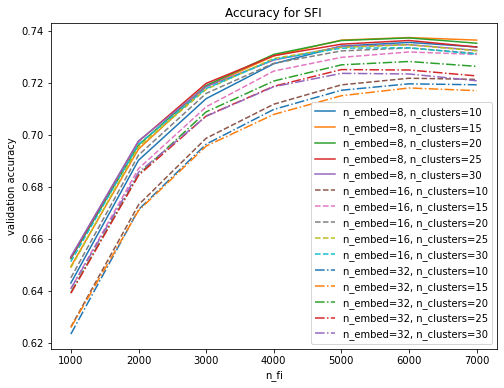

In [151]:
# obtain the accuracy, precision, recall, and F1 score for each combination of parameters
acc_matrix_sfi = np.zeros((3, 5, 7))
for index_k, k in enumerate([8, 16, 32]):
    for index_n_clusters, n_clusters in enumerate([10, 15, 20, 25, 30]):
        for index_n_top_itemsets, n_top_itemsets in enumerate(range(1000, 7001, 1000)):
            acc_matrix_sfi[index_k, index_n_clusters, index_n_top_itemsets] = acc_list_sfi[(k, n_clusters, n_top_itemsets)]

# plot the accuracy for each combination of parameters
plt.figure(figsize=(8,6))
styles = ['-', '--', '-.']
for index_k, k in enumerate([8, 16, 32]):
    for index_n_clusters, n_clusters in enumerate([10, 15, 20, 25, 30]):
        plt.plot(range(1000, 7001, 1000), acc_matrix_sfi[index_k, index_n_clusters, :], styles[index_k], label=f'n_embed={k}, n_clusters={n_clusters}')
plt.title('Accuracy for SFI')
plt.xlabel('n_fi')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

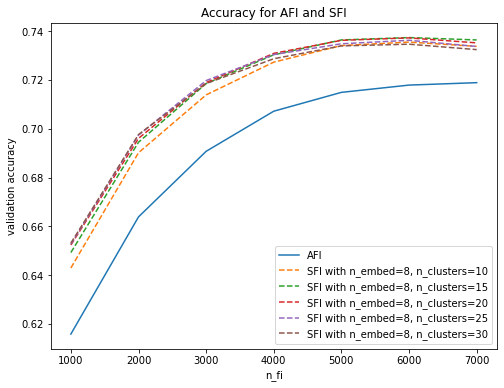

In [152]:
# plot a comparison between FI and SFI
plt.figure(figsize=(8,6))
plt.plot(range(1000, 7001, 1000), acc_list, label='AFI')
for index_n_clusters in range(5):
    plt.plot(range(1000, 7001, 1000), acc_matrix_sfi[0, index_n_clusters, :], '--', 
             label='SFI with n_embed=8, n_clusters={}'.format([10, 15, 20, 25, 30][index_n_clusters]))
plt.title('Accuracy for AFI and SFI')
plt.xlabel('n_fi')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

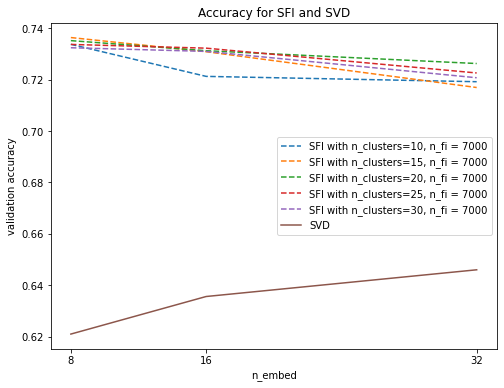

In [149]:
# plot a comparison between SFI and SVD
plt.figure(figsize=(8,6))
for index_n_clusters in range(5):
    plt.plot([8, 16, 32], acc_matrix_sfi[:, index_n_clusters, -1], '--', 
             label='SFI with n_clusters={}, n_fi = 7000'.format([10, 15, 20, 25, 30][index_n_clusters]))
plt.plot([8, 16, 32], acc_list_svd, label='SVD')
plt.title('Accuracy for SFI and SVD')
plt.xlabel('n_embed')
plt.xticks([8, 16, 32])
plt.ylabel('validation accuracy')
plt.legend()
plt.show()
